<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asym(30%)</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.3
loss_function = 'DampedSCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedSCELoss_aircrafts_asym_0.3_0.25_baseline
Model Features: DampedSCELoss_aircrafts_asym_0.3_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_asym_0.3_0.25
Csv save: DampedSCELoss_aircrafts_asym_0.3_0.25
Saving features from Scheme delta = 0.25: DampedSCELoss_aircrafts_asym_0.3_0.5
Saving csv for damp_2: DampedSCELoss_aircrafts_asym_0.3_0.5


# Declaration of Efficient Net family with Resolution, Epochs, Learning Rate, Batch size and Label smoothing values

In [4]:
architecture = 'efficientnet-b4'
logfile = 'efficientnet-b0-MENA.csv'

## The tables
effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [5]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [6]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

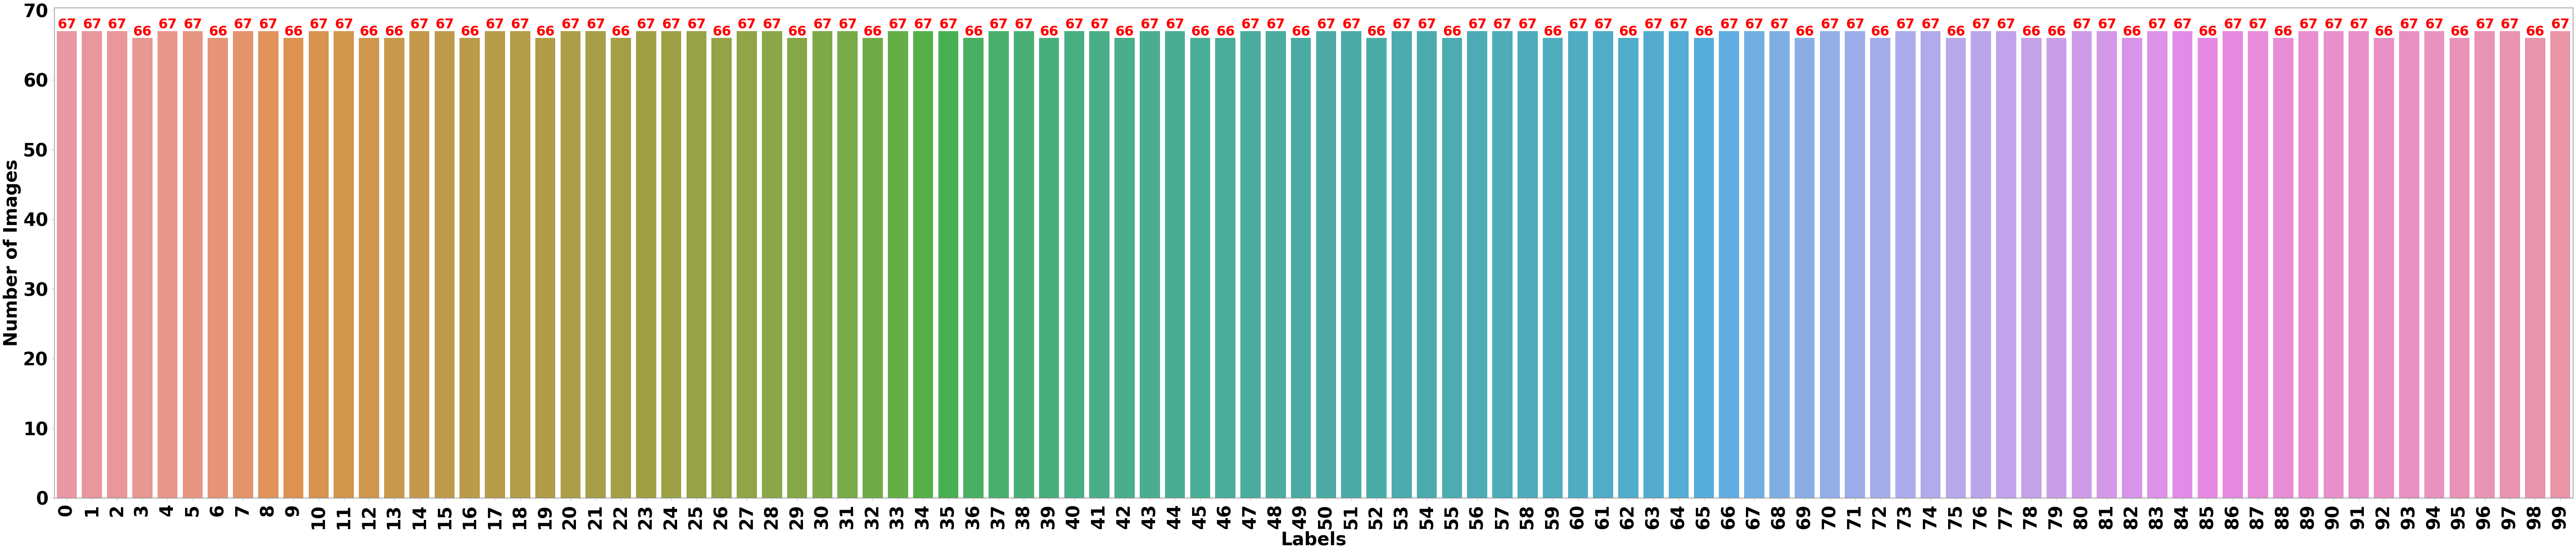

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [8]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [9]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [10]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [11]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [12]:
my_list = sorted_df.Label.unique()

In [13]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [14]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [16]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [17]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

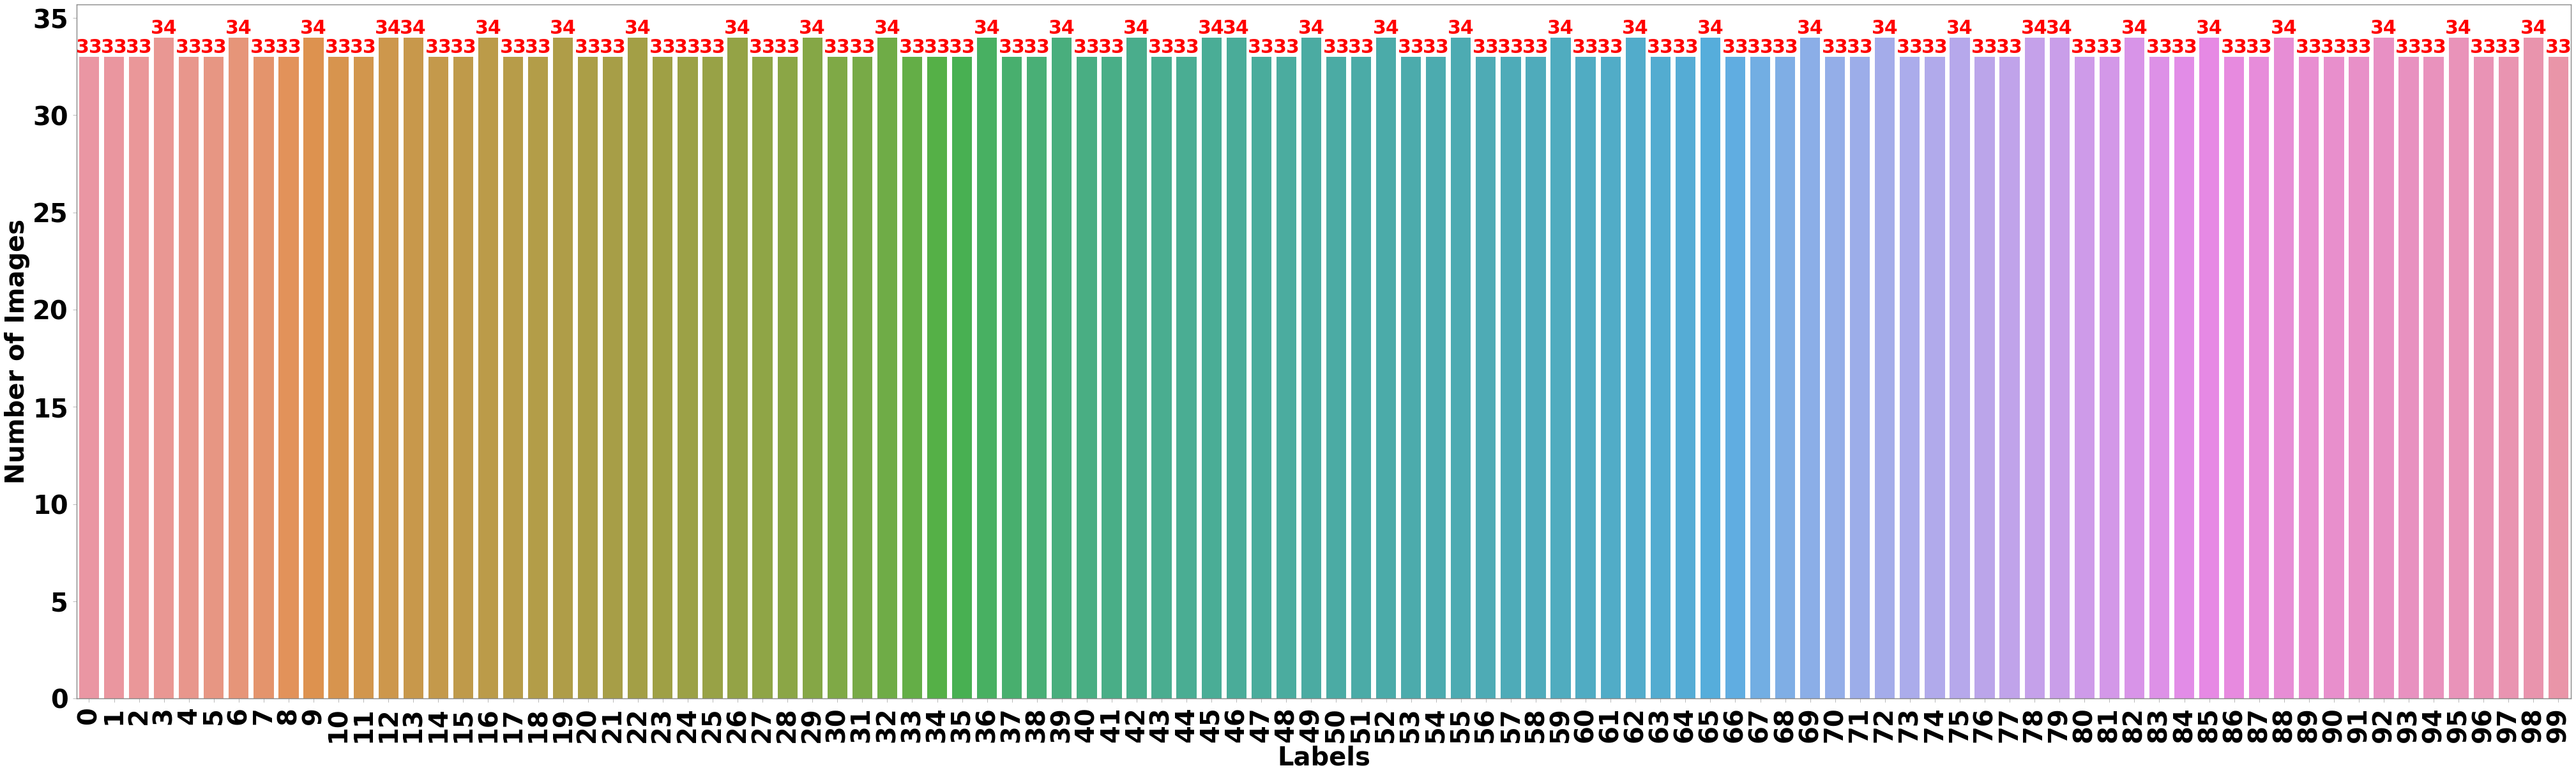

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [22]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [23]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


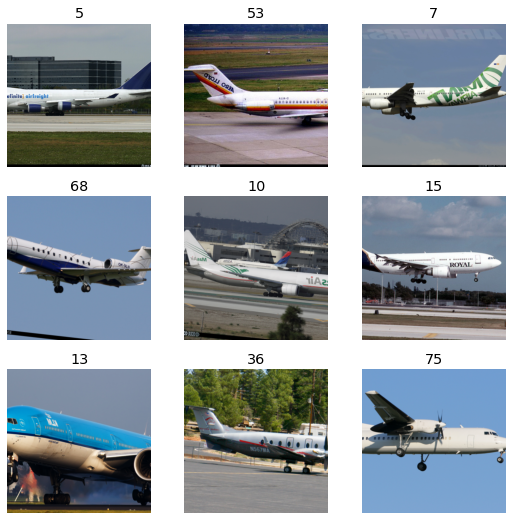

In [24]:
data0.show_batch()

In [25]:
import damped_losses as losses
loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=0.0, reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes = num_classes)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [26]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= sce_aircrafts_asym_0.3_baseline


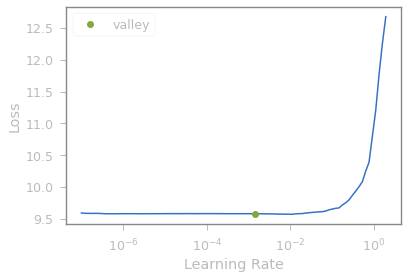

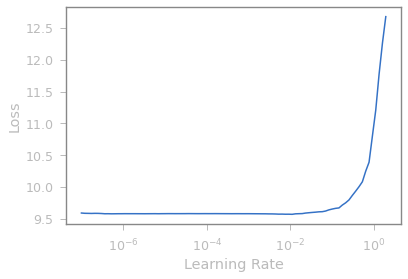

In [29]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,9.288214,9.230986,0.084021,01:49
1,8.882492,9.700658,0.078770,01:49
2,8.616309,9.254351,0.126782,01:49
3,8.026368,8.347735,0.210053,01:49
4,7.671174,7.766238,0.278320,01:49
5,6.837537,7.071476,0.360090,01:49
6,6.108500,6.531688,0.423106,01:49
7,5.411994,6.059371,0.477119,01:49
8,5.058680,5.922226,0.497374,01:49
9,4.811102,5.924180,0.492873,01:49


Better model found at epoch 0 with accuracy value: 0.08402100205421448.


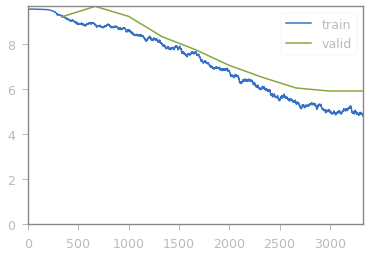

Better model found at epoch 2 with accuracy value: 0.12678170204162598.
Better model found at epoch 3 with accuracy value: 0.2100525200366974.
Better model found at epoch 4 with accuracy value: 0.2783195674419403.
Better model found at epoch 5 with accuracy value: 0.3600900173187256.
Better model found at epoch 6 with accuracy value: 0.42310577630996704.
Better model found at epoch 7 with accuracy value: 0.4771192669868469.
Better model found at epoch 8 with accuracy value: 0.49737435579299927.


In [30]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,4.976398,5.914763,0.499625,01:49
1,4.908376,5.889885,0.498875,01:49
2,4.865179,5.973559,0.481620,01:49
3,4.664708,5.880539,0.504126,01:49
4,4.804054,6.208743,0.473368,01:49
5,4.865905,6.263500,0.460615,01:49
6,5.026200,6.337538,0.459115,01:48
7,5.106315,6.676586,0.423856,01:49
8,5.330251,6.437689,0.444111,01:49
9,5.408267,6.627057,0.429857,01:49


Better model found at epoch 0 with accuracy value: 0.49962490797042847.


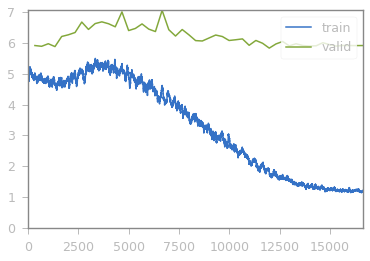

Better model found at epoch 3 with accuracy value: 0.5041260123252869.
Better model found at epoch 35 with accuracy value: 0.5108777284622192.
Better model found at epoch 38 with accuracy value: 0.5116279125213623.


In [32]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [33]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)
# inter_test0 = ClassificationInterpretation.from_learner(tester0, dl =data_test)
# inter_test0.plot_confusion_matrix(figsize = (50,60))

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.6394)


 ------------
 B0|Epochs|20|8056   |
 -----------------------------

In [34]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.6466)


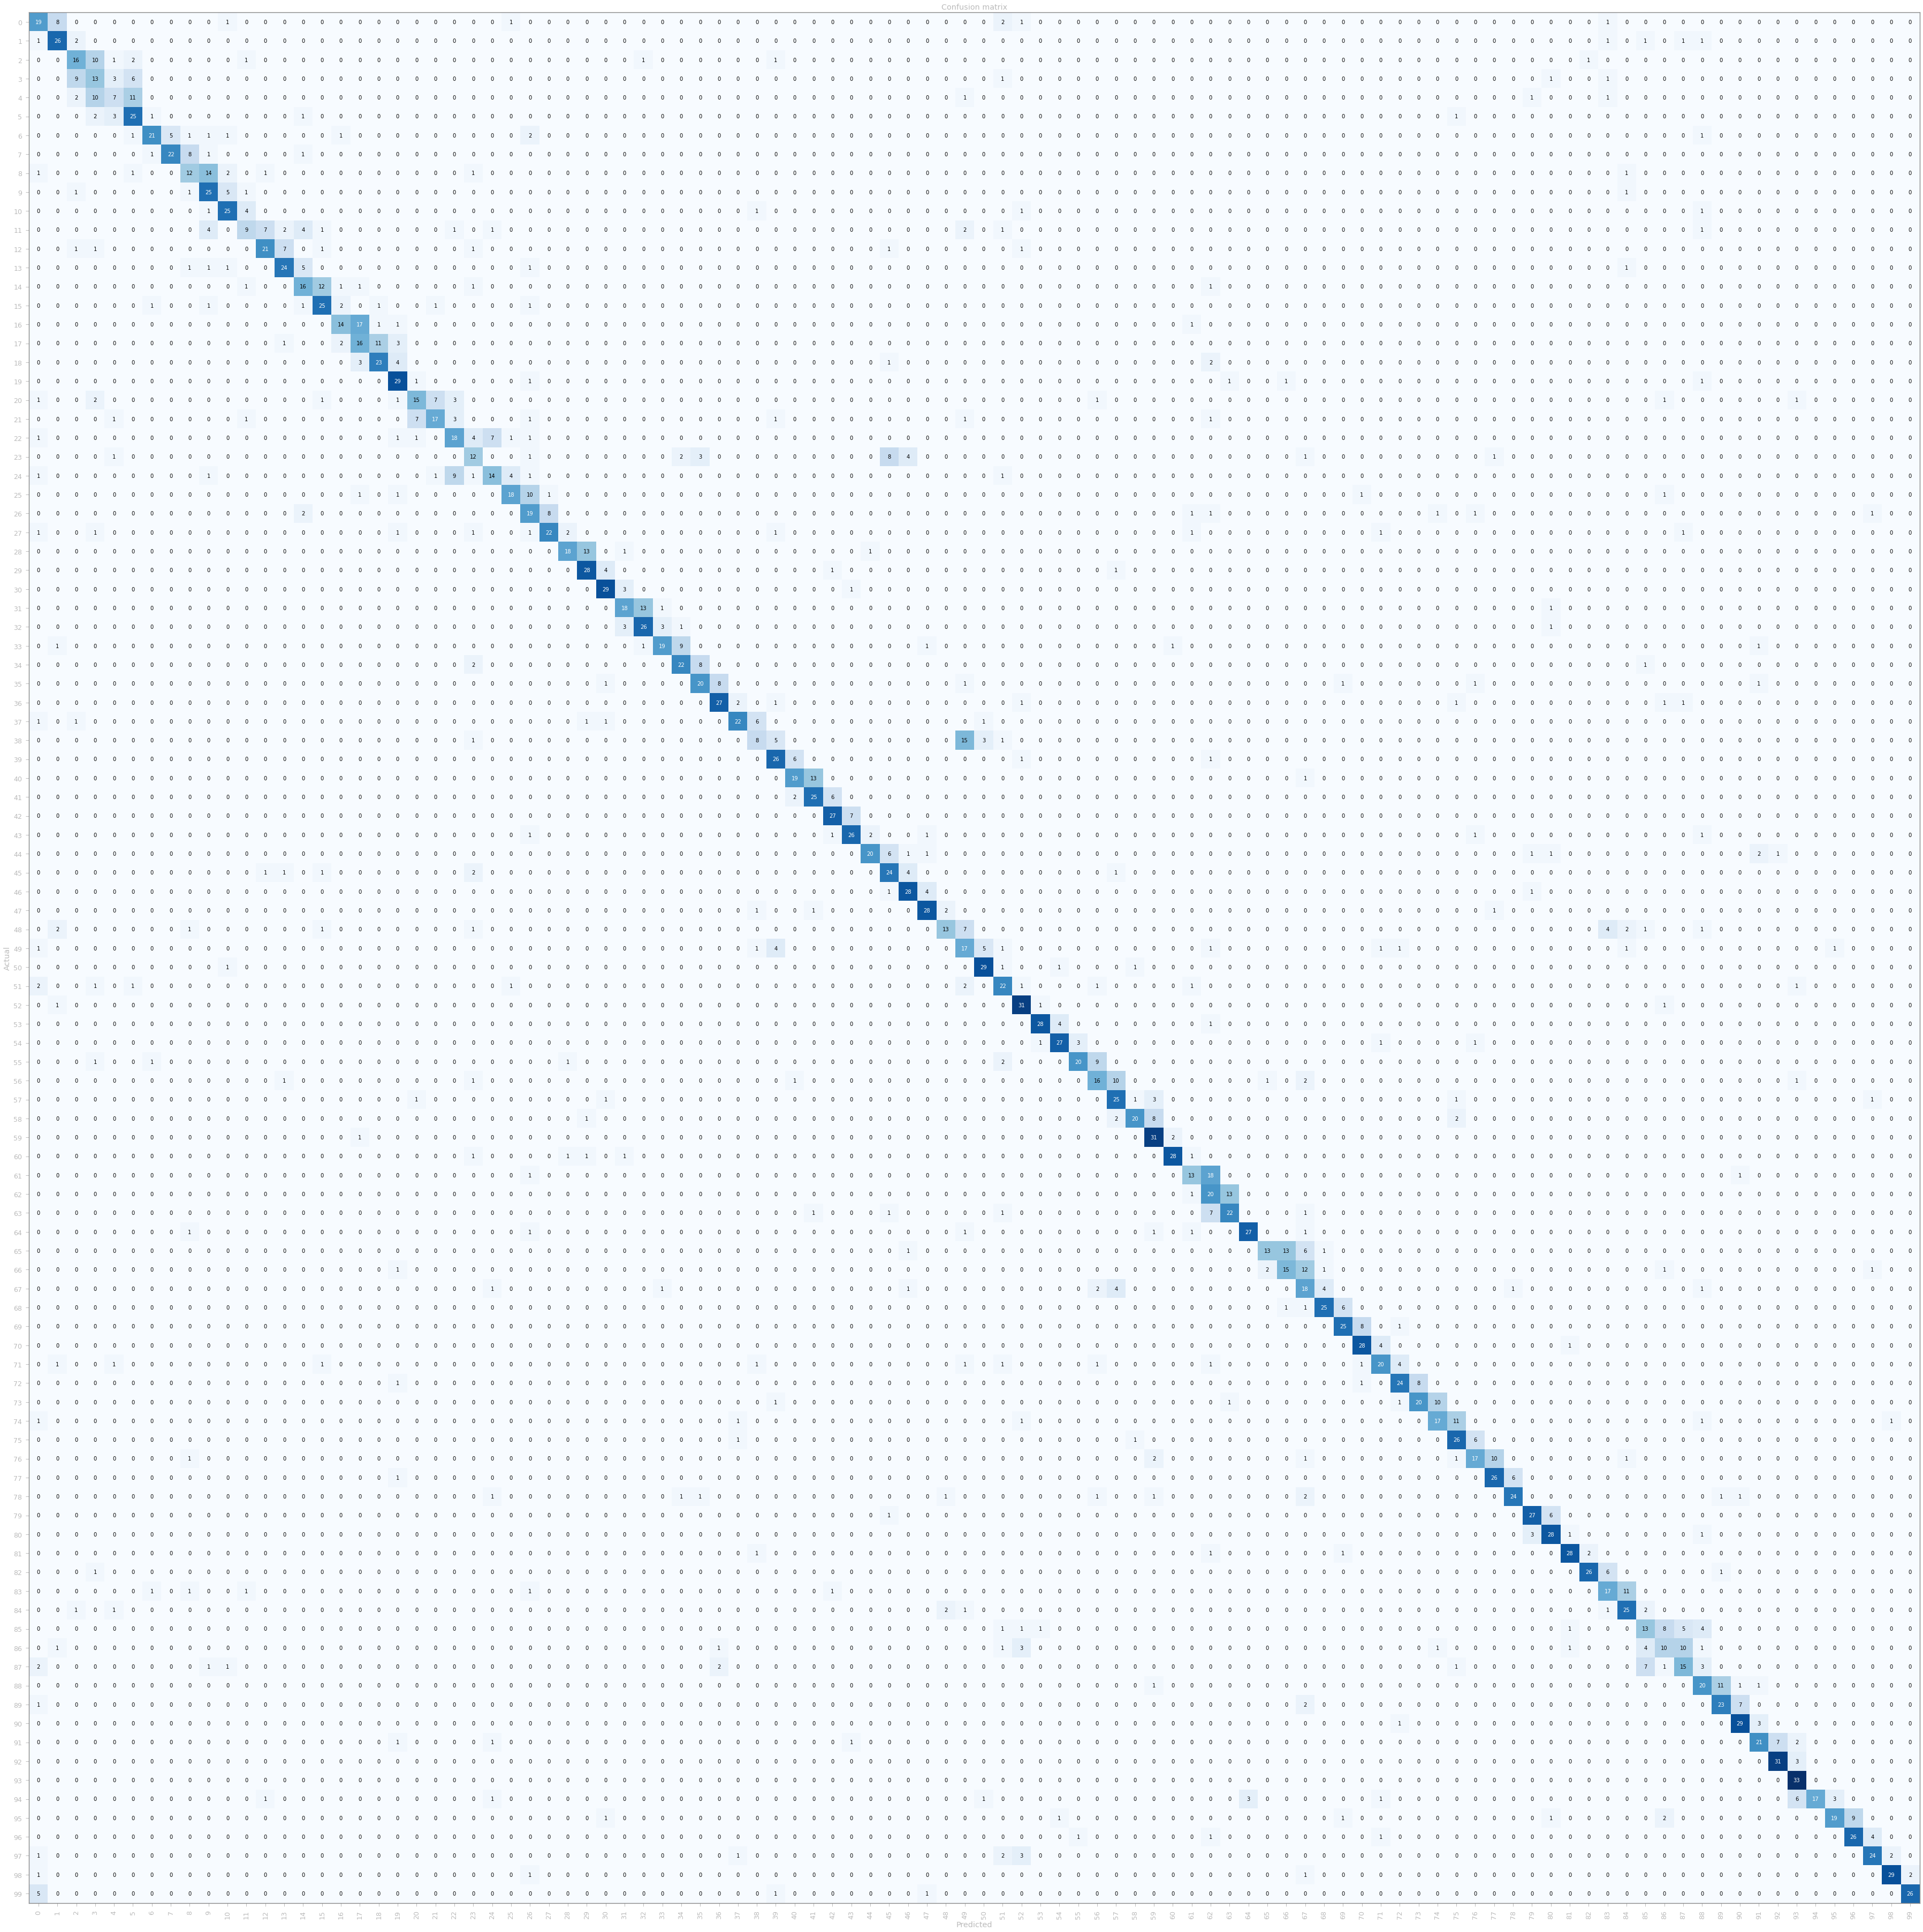

In [35]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [36]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [37]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/sce_aircrafts_asym_0.3_baseline.pth'

# CYFLOD Scheme

In [30]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples = k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,2.428500,2.151303,0.875285,01:49


Better model found at epoch 0 with accuracy value: 0.8752851486206055.


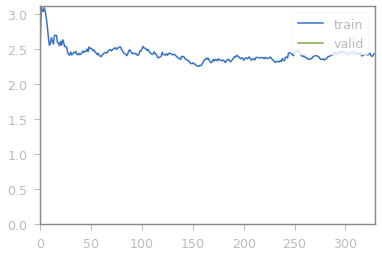

************Round:  0
TTA Accuracy:0.6642664074897766
cycle 0 Error Rate is [{0: (1.3199340032998386, 33.57335925102234)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 83 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6496


epoch,train_loss,valid_loss,accuracy,time
0,2.344422,2.027426,0.889915,01:46


Better model found at epoch 0 with accuracy value: 0.8899153470993042.


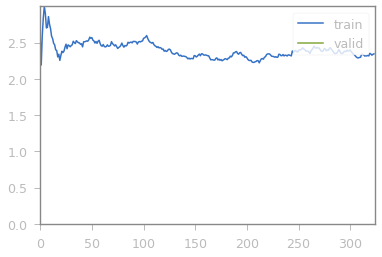

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 78 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6418


epoch,train_loss,valid_loss,accuracy,time
0,2.220978,2.159765,0.875292,01:45


Better model found at epoch 0 with accuracy value: 0.8752923011779785.


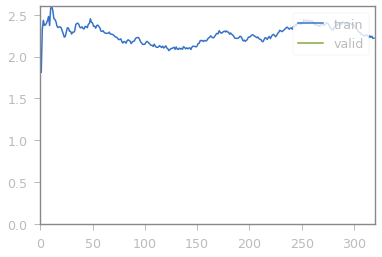

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 74 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6344


epoch,train_loss,valid_loss,accuracy,time
0,2.296760,2.028733,0.891167,01:45


Better model found at epoch 0 with accuracy value: 0.891167163848877.


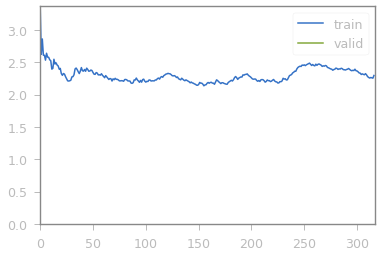

************Round:  3
TTA Accuracy:0.6726672649383545
cycle 0 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 80 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6264


epoch,train_loss,valid_loss,accuracy,time
0,2.116872,2.133213,0.879393,01:43


Better model found at epoch 0 with accuracy value: 0.8793929815292358.


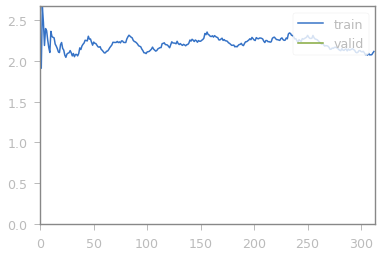

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 71 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6193


epoch,train_loss,valid_loss,accuracy,time
0,2.210893,1.858622,0.908724,01:43


Better model found at epoch 0 with accuracy value: 0.908723771572113.


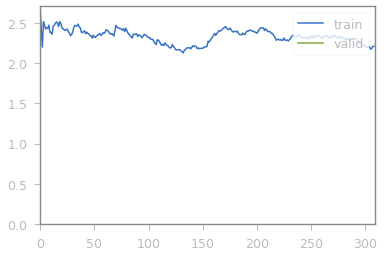

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 76 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6117


epoch,train_loss,valid_loss,accuracy,time
0,2.165631,1.837741,0.910057,01:41


Better model found at epoch 0 with accuracy value: 0.9100572466850281.


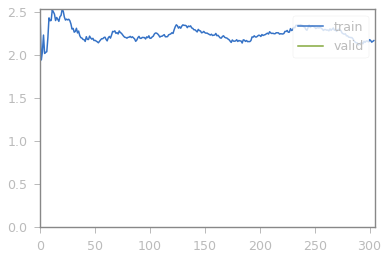

************Round:  6
TTA Accuracy:0.6780678033828735
cycle 0 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 71 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6046


epoch,train_loss,valid_loss,accuracy,time
0,2.168617,2.026408,0.891646,01:41


Better model found at epoch 0 with accuracy value: 0.8916459679603577.


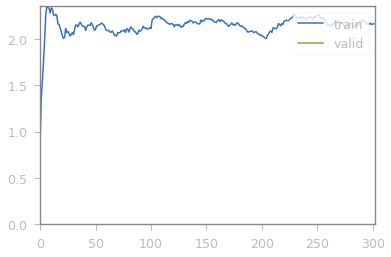

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 77 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5969


epoch,train_loss,valid_loss,accuracy,time
0,2.334984,1.868025,0.905281,01:37


Better model found at epoch 0 with accuracy value: 0.9052808284759521.


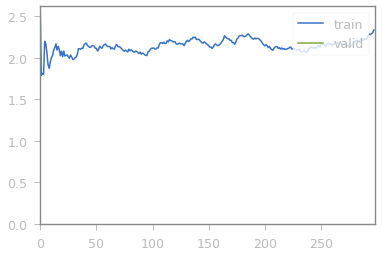

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 54
Min probability = 0.7476923076923078
Dropped 67 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5902


epoch,train_loss,valid_loss,accuracy,time
0,2.084747,1.908510,0.901695,01:39


Better model found at epoch 0 with accuracy value: 0.9016948938369751.


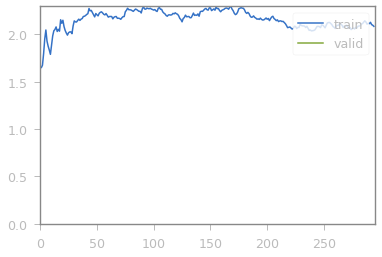

************Round:  9
TTA Accuracy:0.6771677136421204
cycle 0 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 72 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5830


epoch,train_loss,valid_loss,accuracy,time
0,2.189949,1.773479,0.914237,01:36


Better model found at epoch 0 with accuracy value: 0.9142367243766785.


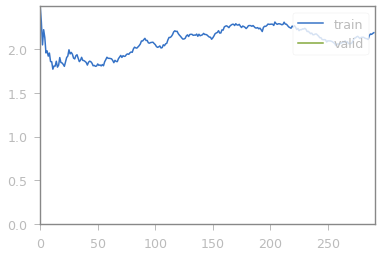

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 63 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5767


epoch,train_loss,valid_loss,accuracy,time
0,2.099227,1.923969,0.897658,01:36


Better model found at epoch 0 with accuracy value: 0.8976582884788513.


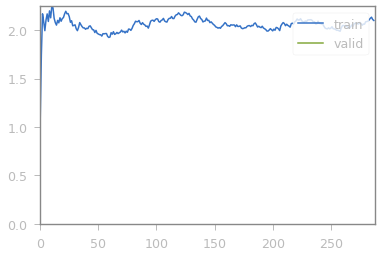

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 47
Min probability = 0.6609375000000001
Dropped 68 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5699


epoch,train_loss,valid_loss,accuracy,time
0,2.057709,1.994275,0.889377,01:34


Better model found at epoch 0 with accuracy value: 0.8893766403198242.


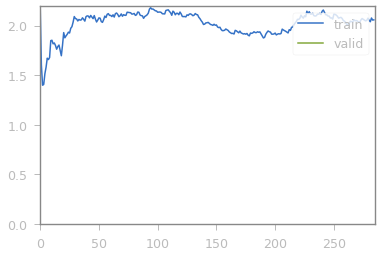

************Round:  12
TTA Accuracy:0.6777677536010742
cycle 0 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 47
Min probability = 0.6609375000000001
Dropped 62 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5637


epoch,train_loss,valid_loss,accuracy,time
0,2.130715,1.885205,0.906832,01:33


Better model found at epoch 0 with accuracy value: 0.9068322777748108.


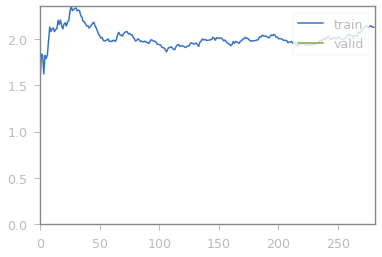

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 46
Min probability = 0.6571428571428571
Dropped 73 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5564


epoch,train_loss,valid_loss,accuracy,time
0,1.985496,1.724797,0.919964,01:32


Better model found at epoch 0 with accuracy value: 0.9199640154838562.


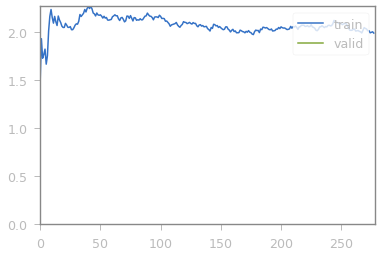

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,1.962055,1.729241,0.919453,01:48


Better model found at epoch 0 with accuracy value: 0.9194529056549072.


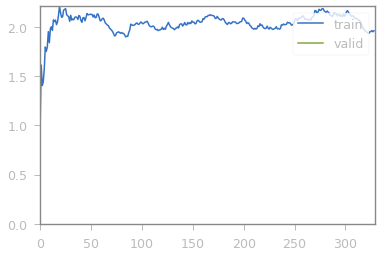

************Round:  0
TTA Accuracy:0.6801680326461792
cycle 1 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 77 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6504


epoch,train_loss,valid_loss,accuracy,time
0,1.961788,1.849610,0.906923,01:46


Better model found at epoch 0 with accuracy value: 0.9069230556488037.


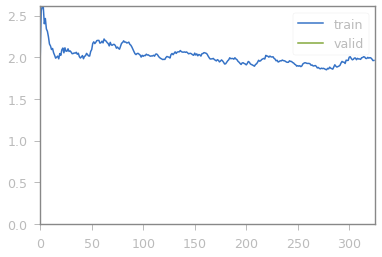

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 74 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6430


epoch,train_loss,valid_loss,accuracy,time
0,2.141180,1.740294,0.917574,01:45


Better model found at epoch 0 with accuracy value: 0.917573869228363.


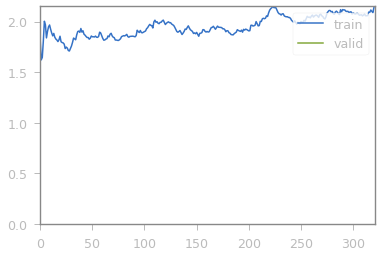

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 86 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6344


epoch,train_loss,valid_loss,accuracy,time
0,1.927999,1.730407,0.917981,01:44


Better model found at epoch 0 with accuracy value: 0.9179810881614685.


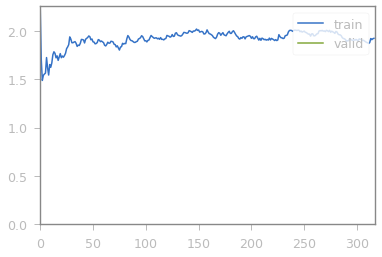

************Round:  3
TTA Accuracy:0.6789678931236267
cycle 1 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 75 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6269


epoch,train_loss,valid_loss,accuracy,time
0,2.088681,1.675780,0.925778,01:42


Better model found at epoch 0 with accuracy value: 0.9257781505584717.


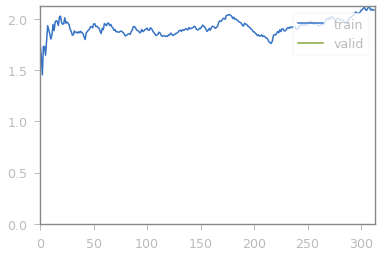

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 64 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6205


epoch,train_loss,valid_loss,accuracy,time
0,1.866684,1.779249,0.914585,01:41


Better model found at epoch 0 with accuracy value: 0.9145849943161011.


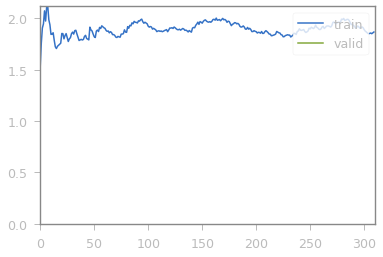

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 79 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6126


epoch,train_loss,valid_loss,accuracy,time
0,1.855541,1.768239,0.913469,01:40


Better model found at epoch 0 with accuracy value: 0.9134693741798401.


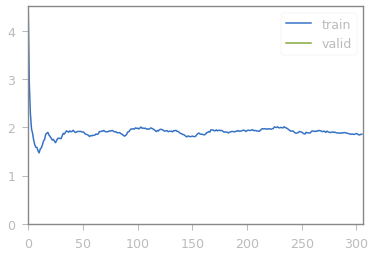

************Round:  6
TTA Accuracy:0.679267942905426
cycle 1 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 54 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6072


epoch,train_loss,valid_loss,accuracy,time
0,1.934316,1.701129,0.920923,01:39


Better model found at epoch 0 with accuracy value: 0.920922577381134.


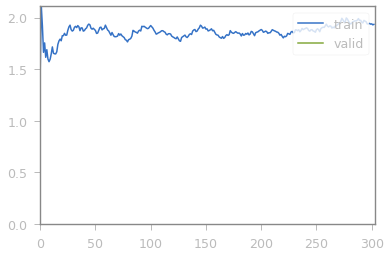

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 66 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6006


epoch,train_loss,valid_loss,accuracy,time
0,1.947496,1.680605,0.928393,01:38


Better model found at epoch 0 with accuracy value: 0.9283930063247681.


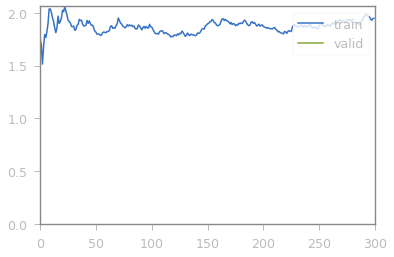

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 82 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5924


epoch,train_loss,valid_loss,accuracy,time
0,1.817487,1.677811,0.924831,01:37


Better model found at epoch 0 with accuracy value: 0.9248310923576355.


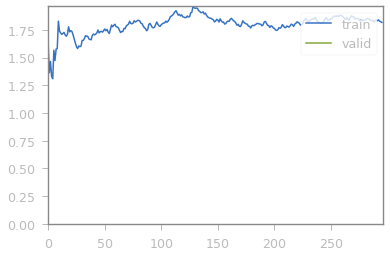

************Round:  9
TTA Accuracy:0.6744674444198608
cycle 1 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 50
Min probability = 0.6818181818181819
Dropped 65 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5859


epoch,train_loss,valid_loss,accuracy,time
0,1.809860,1.643910,0.927412,01:36


Better model found at epoch 0 with accuracy value: 0.9274124503135681.


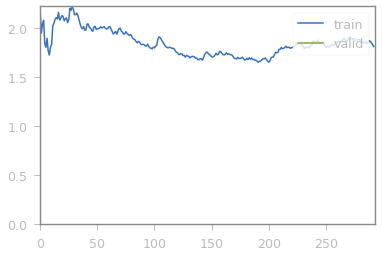

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 49
Min probability = 0.6681818181818182
Dropped 64 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5795


epoch,train_loss,valid_loss,accuracy,time
0,1.865920,1.614319,0.932701,01:35


Better model found at epoch 0 with accuracy value: 0.9327005743980408.


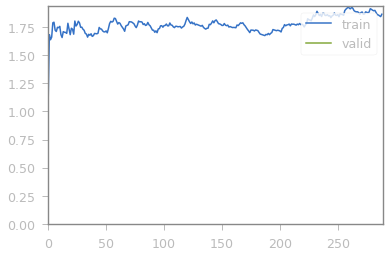

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 48
Min probability = 0.6545454545454545
Dropped 61 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5734


epoch,train_loss,valid_loss,accuracy,time
0,1.909148,1.558582,0.935428,01:36


Better model found at epoch 0 with accuracy value: 0.9354275465011597.


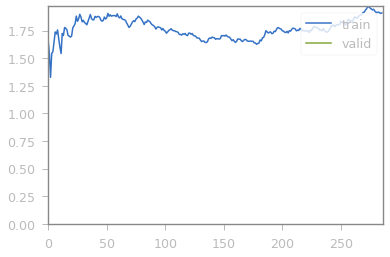

************Round:  12
TTA Accuracy:0.6681668162345886
cycle 1 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 66
Min frequency is 48
Min probability = 0.6545454545454545
Dropped 70 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5664


epoch,train_loss,valid_loss,accuracy,time
0,1.832180,1.497693,0.941696,01:33


Better model found at epoch 0 with accuracy value: 0.9416961073875427.


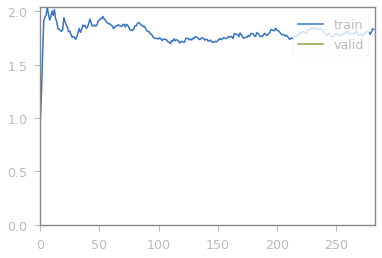

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 65
Min frequency is 46
Min probability = 0.6369230769230769
Dropped 65 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5599


epoch,train_loss,valid_loss,accuracy,time
0,1.750107,1.503428,0.941912,01:34


Better model found at epoch 0 with accuracy value: 0.9419124126434326.


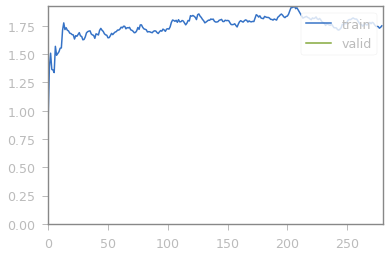

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 83 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6584


epoch,train_loss,valid_loss,accuracy,time
0,1.776660,1.524828,0.939210,01:48


Better model found at epoch 0 with accuracy value: 0.9392096996307373.


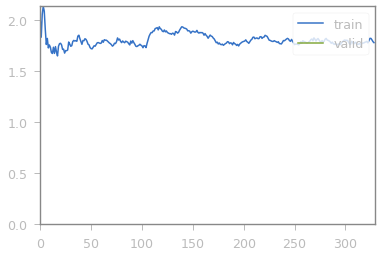

************Round:  0
TTA Accuracy:0.6756675839424133
cycle 2 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114), 30: (1.2449377531123407, 32.43324160575867)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 82 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6502


epoch,train_loss,valid_loss,accuracy,time
0,1.808357,1.508395,0.943077,01:47


Better model found at epoch 0 with accuracy value: 0.9430769085884094.


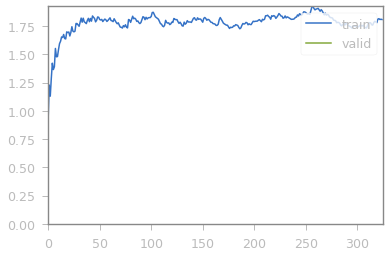

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 75 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6427


epoch,train_loss,valid_loss,accuracy,time
0,1.796568,1.501202,0.943969,01:46


Better model found at epoch 0 with accuracy value: 0.9439688920974731.


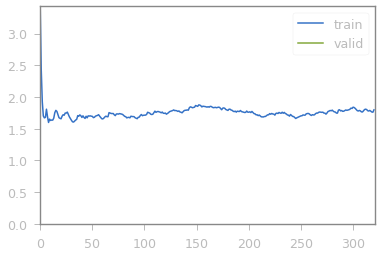

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6345


epoch,train_loss,valid_loss,accuracy,time
0,1.625464,1.441807,0.947991,01:44


Better model found at epoch 0 with accuracy value: 0.9479905366897583.


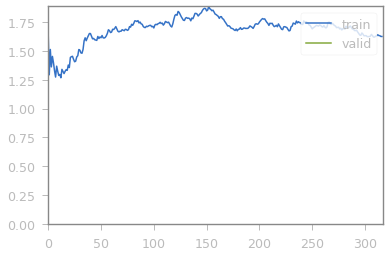

************Round:  3
TTA Accuracy:0.6612661480903625
cycle 2 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114), 30: (1.2449377531123407, 32.43324160575867), 33: (4.829758512074401, 33.873385190963745)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6268


epoch,train_loss,valid_loss,accuracy,time
0,1.680143,1.409601,0.953711,01:42


Better model found at epoch 0 with accuracy value: 0.9537110924720764.


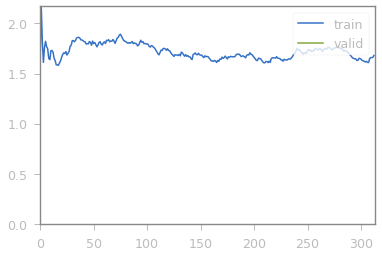

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 74 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6194


epoch,train_loss,valid_loss,accuracy,time
0,1.698119,1.488579,0.941842,01:41


Better model found at epoch 0 with accuracy value: 0.9418416619300842.


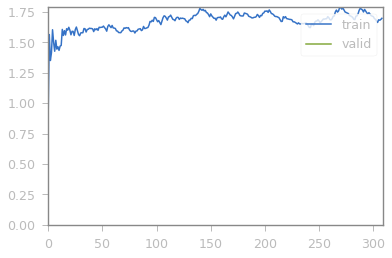

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 74 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6120


epoch,train_loss,valid_loss,accuracy,time
0,1.683395,1.389927,0.950163,01:40


Better model found at epoch 0 with accuracy value: 0.9501634240150452.


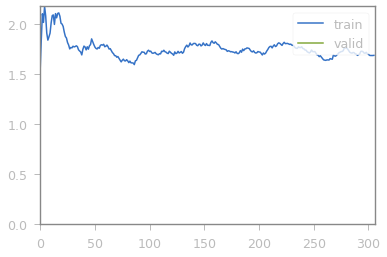

************Round:  6
TTA Accuracy:0.6693669557571411
cycle 2 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114), 30: (1.2449377531123407, 32.43324160575867), 33: (4.829758512074401, 33.873385190963745), 36: (8.204589770511472, 33.06330442428589)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 78 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6042


epoch,train_loss,valid_loss,accuracy,time
0,1.628698,1.469716,0.943709,01:39


Better model found at epoch 0 with accuracy value: 0.943708598613739.


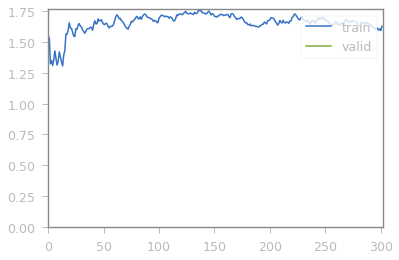

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 71 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5971


epoch,train_loss,valid_loss,accuracy,time
0,1.675833,1.416634,0.951424,01:37


Better model found at epoch 0 with accuracy value: 0.9514237642288208.


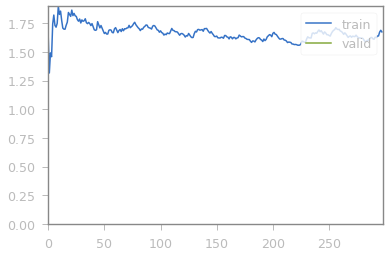

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 77 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5894


epoch,train_loss,valid_loss,accuracy,time
0,1.620716,1.364333,0.956706,01:37


Better model found at epoch 0 with accuracy value: 0.9567062854766846.


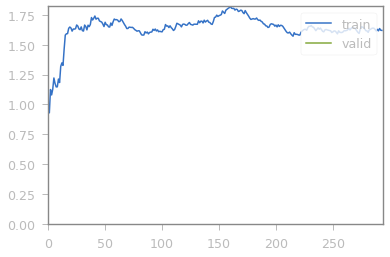

************Round:  9
TTA Accuracy:0.6708670854568481
cycle 2 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114), 30: (1.2449377531123407, 32.43324160575867), 33: (4.829758512074401, 33.873385190963745), 36: (8.204589770511472, 33.06330442428589), 39: (11.59442027898605, 32.913291454315186)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 74 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5820


epoch,train_loss,valid_loss,accuracy,time
0,1.577667,1.281744,0.964777,01:35


Better model found at epoch 0 with accuracy value: 0.9647766351699829.


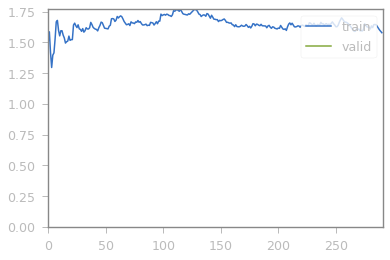

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 71 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5749


epoch,train_loss,valid_loss,accuracy,time
0,1.612305,1.373551,0.955614,01:36


Better model found at epoch 0 with accuracy value: 0.9556135535240173.


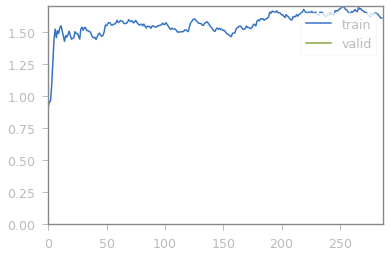

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 43
Min probability = 0.6046875
Dropped 61 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5688


epoch,train_loss,valid_loss,accuracy,time
0,1.572378,1.339720,0.959543,01:33


Better model found at epoch 0 with accuracy value: 0.9595426321029663.


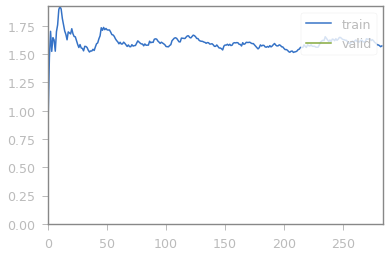

************Round:  12
TTA Accuracy:0.6654665470123291
cycle 2 Error Rate is [{0: (1.3199340032998386, 33.57335925102234), 3: (4.844757762111895, 32.73327350616455), 6: (8.249587520623969, 32.19321966171265), 9: (11.474426278686067, 32.283228635787964), 12: (14.51927403629818, 32.22322463989258), 15: (1.2899355032248372, 31.98319673538208), 18: (4.844757762111895, 32.10321068763733), 21: (8.11459427028649, 32.0732057094574), 24: (11.144442777861109, 32.553255558013916), 27: (13.99430028498575, 33.18331837654114), 30: (1.2449377531123407, 32.43324160575867), 33: (4.829758512074401, 33.873385190963745), 36: (8.204589770511472, 33.06330442428589), 39: (11.59442027898605, 32.913291454315186), 42: (14.68426578671066, 33.45334529876709)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 42
Min probability = 0.6
Dropped 62 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5626


epoch,train_loss,valid_loss,accuracy,time
0,1.516449,1.348826,0.956444,01:33


Better model found at epoch 0 with accuracy value: 0.9564444422721863.


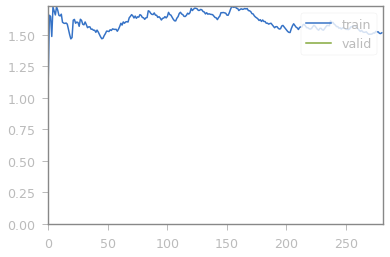

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 42
Min probability = 0.6
Dropped 58 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5568


epoch,train_loss,valid_loss,accuracy,time
0,1.555803,1.417730,0.949686,01:31


Better model found at epoch 0 with accuracy value: 0.9496855139732361.


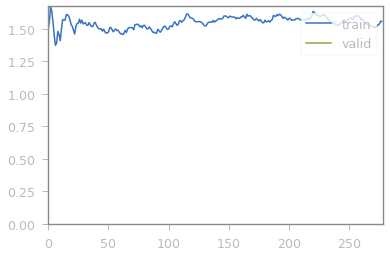

In [39]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
k_samples = 100       # Number of samples for top losses filtering
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 0.1, beta = 1.0, delta=delta, reduction='mean')      
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         

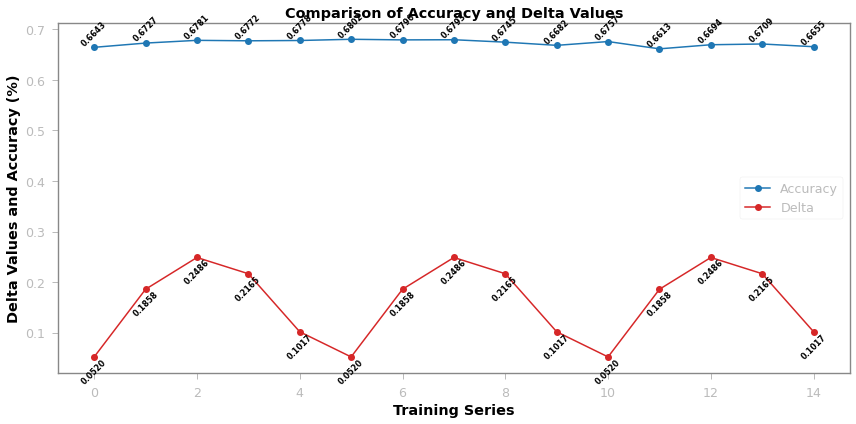

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()

# With delta = 0.50

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 45 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6622


epoch,train_loss,valid_loss,accuracy,time
0,1.147639,0.933155,0.998489,01:56


Better model found at epoch 0 with accuracy value: 0.9984894394874573.


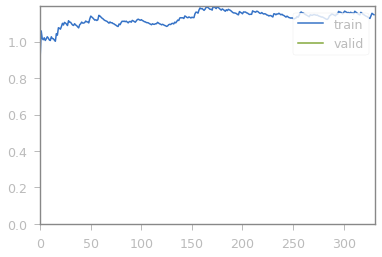

************Round:  0
TTA Accuracy:0.6432643532752991
cycle 0 Error Rate is [{0: (0.6749662516874144, 35.67356467247009)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 37 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6585


epoch,train_loss,valid_loss,accuracy,time
0,1.153342,0.920988,1.000000,01:48


Better model found at epoch 0 with accuracy value: 1.0.


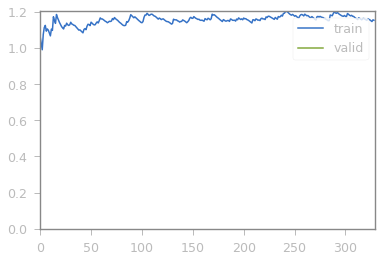

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 37 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6548


epoch,train_loss,valid_loss,accuracy,time
0,1.116936,0.942296,0.997708,01:49


Better model found at epoch 0 with accuracy value: 0.9977082014083862.


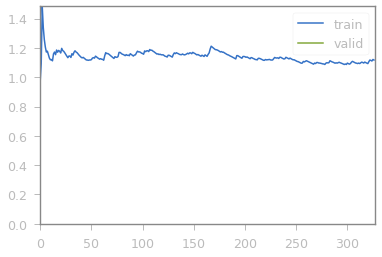

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 32 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6516


epoch,train_loss,valid_loss,accuracy,time
0,1.093533,0.946140,0.997698,01:48


Better model found at epoch 0 with accuracy value: 0.9976975917816162.


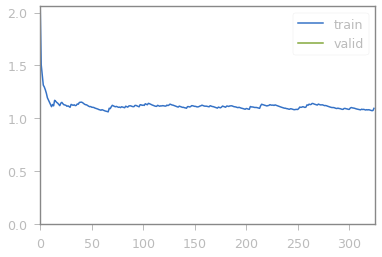

************Round:  3
TTA Accuracy:0.6465646624565125
cycle 0 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 33 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6483


epoch,train_loss,valid_loss,accuracy,time
0,1.105290,0.943551,0.997685,01:46


Better model found at epoch 0 with accuracy value: 0.9976851940155029.


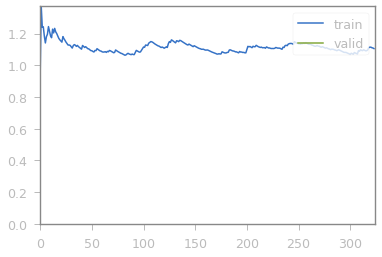

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 34 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6449


epoch,train_loss,valid_loss,accuracy,time
0,1.141044,0.956014,0.996897,01:48


Better model found at epoch 0 with accuracy value: 0.9968968033790588.


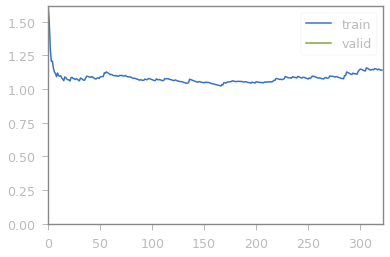

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 37 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6412


epoch,train_loss,valid_loss,accuracy,time
0,1.103868,0.944167,0.997660,01:46


Better model found at epoch 0 with accuracy value: 0.9976599216461182.


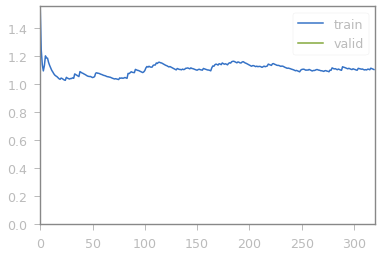

************Round:  6
TTA Accuracy:0.6483648419380188
cycle 0 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755), 6: (3.824808759562026, 35.16351580619812)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 49
Min probability = 0.6582089552238806
Dropped 39 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6373


epoch,train_loss,valid_loss,accuracy,time
0,1.086793,0.916870,1.000000,01:47


Better model found at epoch 0 with accuracy value: 1.0.


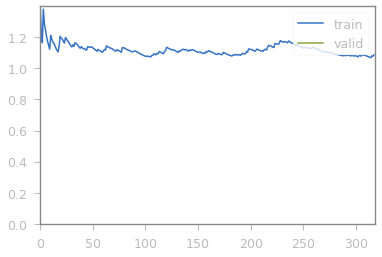

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 35 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
6338


epoch,train_loss,valid_loss,accuracy,time
0,1.061161,0.936701,0.998421,01:45


Better model found at epoch 0 with accuracy value: 0.9984214901924133.


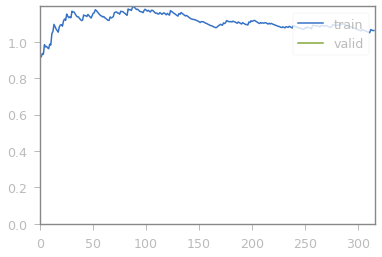

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 29 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
6309


epoch,train_loss,valid_loss,accuracy,time
0,1.140208,0.921549,0.999207,01:44


Better model found at epoch 0 with accuracy value: 0.9992069602012634.


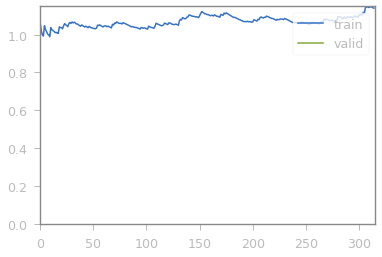

************Round:  9
TTA Accuracy:0.6495649814605713
cycle 0 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755), 6: (3.824808759562026, 35.16351580619812), 9: (5.369731513424325, 35.04350185394287)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 24 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
6285


epoch,train_loss,valid_loss,accuracy,time
0,1.112759,0.920543,1.000000,01:44


Better model found at epoch 0 with accuracy value: 1.0.


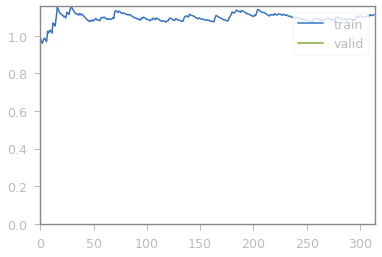

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 28 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
6257


epoch,train_loss,valid_loss,accuracy,time
0,1.105950,0.926184,1.000000,01:43


Better model found at epoch 0 with accuracy value: 1.0.


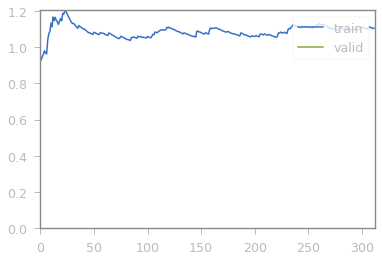

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 27 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
6230


epoch,train_loss,valid_loss,accuracy,time
0,1.057438,0.928909,0.998395,01:45


Better model found at epoch 0 with accuracy value: 0.9983948469161987.


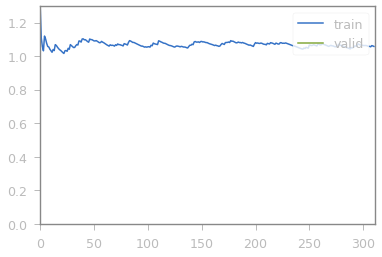

************Round:  12
TTA Accuracy:0.6528652906417847
cycle 0 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755), 6: (3.824808759562026, 35.16351580619812), 9: (5.369731513424325, 35.04350185394287), 12: (6.554672266386685, 34.71347093582153)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 28 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
6202


epoch,train_loss,valid_loss,accuracy,time
0,1.104109,0.921325,1.000000,01:44


Better model found at epoch 0 with accuracy value: 1.0.


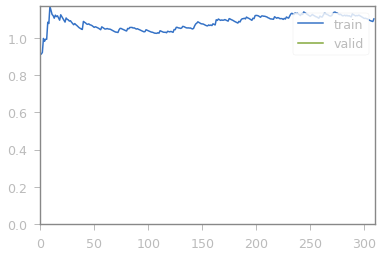

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 67
Min frequency is 40
Min probability = 0.5373134328358209
Dropped 24 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
6178


epoch,train_loss,valid_loss,accuracy,time
0,1.035399,0.918335,1.000000,01:41


Better model found at epoch 0 with accuracy value: 1.0.


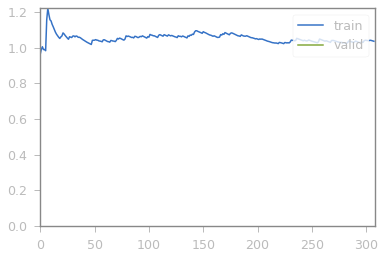

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 43 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6624


epoch,train_loss,valid_loss,accuracy,time
0,1.068188,0.918068,1.000000,01:48


Better model found at epoch 0 with accuracy value: 1.0.


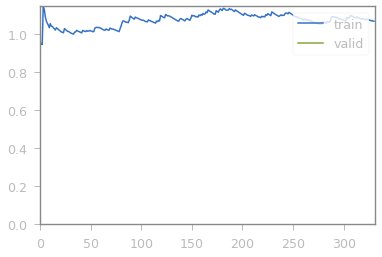

************Round:  0
TTA Accuracy:0.6438643932342529
cycle 1 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755), 6: (3.824808759562026, 35.16351580619812), 9: (5.369731513424325, 35.04350185394287), 12: (6.554672266386685, 34.71347093582153), 15: (0.6449677516124241, 35.61356067657471)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 51
Min probability = 0.6850746268656717
Dropped 29 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6595


epoch,train_loss,valid_loss,accuracy,time
0,1.072731,0.921043,0.999242,01:48


Better model found at epoch 0 with accuracy value: 0.999241828918457.


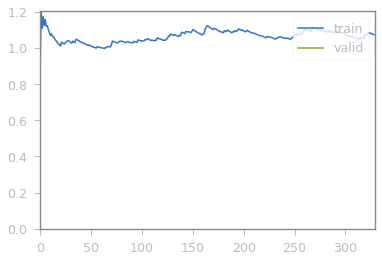

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 35 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6560


epoch,train_loss,valid_loss,accuracy,time
0,1.065786,0.917552,0.999238,01:47


Better model found at epoch 0 with accuracy value: 0.9992377758026123.


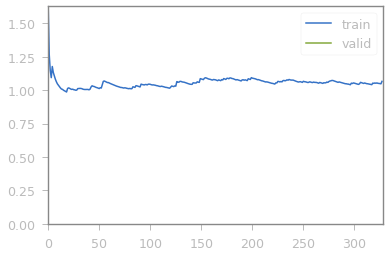

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 31 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6529


epoch,train_loss,valid_loss,accuracy,time
0,1.045225,0.923623,0.999234,01:47


Better model found at epoch 0 with accuracy value: 0.9992337226867676.


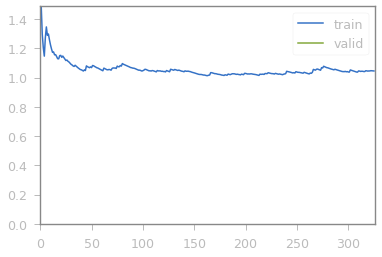

************Round:  3
TTA Accuracy:0.6456645727157593
cycle 1 Error Rate is [{0: (0.6749662516874144, 35.67356467247009), 3: (2.264886755662221, 35.343533754348755), 6: (3.824808759562026, 35.16351580619812), 9: (5.369731513424325, 35.04350185394287), 12: (6.554672266386685, 34.71347093582153), 15: (0.6449677516124241, 35.61356067657471), 18: (2.0698965051747398, 35.43354272842407)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 45
Min probability = 0.6044776119402986
Dropped 30 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6499


epoch,train_loss,valid_loss,accuracy,time
0,1.060747,0.915651,1.000000,01:46


Better model found at epoch 0 with accuracy value: 1.0.


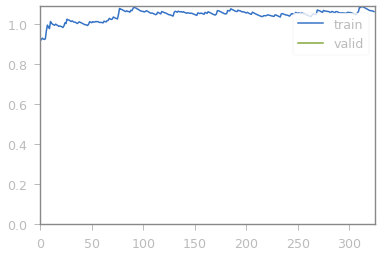

+++++ Training serie: inverse pyramid 5 ++++++++


RuntimeError: CUDA out of memory. Tried to allocate 2.79 GiB (GPU 0; 10.75 GiB total capacity; 893.07 MiB already allocated; 2.80 GiB free; 6.51 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
delta_max = 0.50
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedSCELossFlat(num_classes = num_classes, alpha = 1.0, beta = 1.0, delta=delta, reduction='mean')
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)         